![](encabezado.png)

---

# Tomografía de Refracción Sísmica (TRS)

---
*"(...) refractions are observed only at offsets grater than twice the depth of the refractor".* -Telford et al. (1990)

https://row1.ca/seismic-layers

---

La **Tomografía de Refracción Sísmica** es un método geofísico que utiliza la propagación de ondas mecánicas a través del subsuelo para caracterizar la distribución de velocidades sísmicas.

Las ondas sísmicas, provocadas por una fuente controlada, ya sea un martillo o alguna clase de explosivo, son medidas en la superficie mediante sensores llamados **geófonos**, los cuales registran los movimientos pequeños del suelo provocado por este impacto.

Alguna parte de la energía sísmica que viaja en el subsuelo será **reflejada** a la superficie cuando se encuentre con una interfase; otra parte será **refractada** de tal manera que viaje a través de la interfase y eventualmente regrese a la superficie. Finalmente, una parte adicional de la energía viajará a través de la superficie en forma de **ondas superficiales**, con las cuales se pueden hacer estudios como el MASW.

La TRS en particular es uno de los métodos geofísicos más utilizados, comúnmente para caracterizar el espesor de las capas en las primeras decenas de metros.

---

El ángulo de refracción de una onda sísmica está dada por la ley de Snell, que toma en cuenta el ángulo de incidencia de la onda directa y las velocidades de las capas, de manera que:

$$

\frac{\sin i}{\sin j} = \frac{V_1}{V_2}

$$

o, para calcular el ángulo de refracción $j$ en una capa con velocidad $V_2$ dado un ángulo incidente $i$ en una capa de velocidad $V_1$:
$$

j = \arcsin \left(\frac{V_2 \sin i}{V_1} \right)

$$

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from time import perf_counter

import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.traveltime as tt

%matplotlib inline

# Creación del modelo de capas

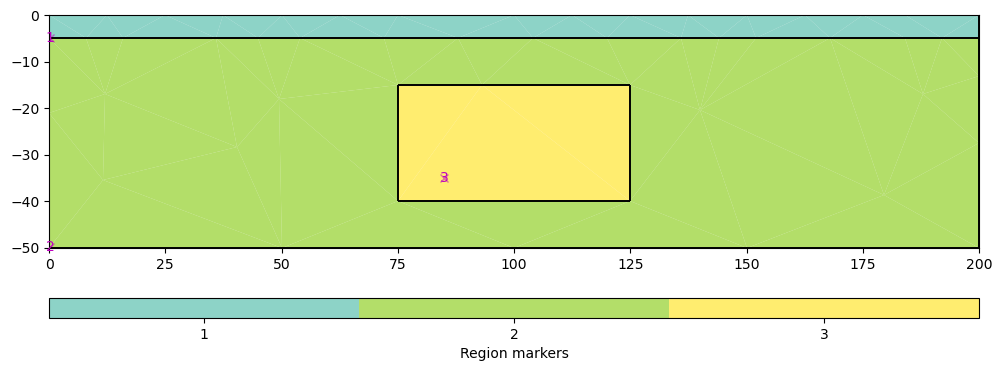

In [11]:
# Se crea un objeto de conteo simplemente por cuestiones de benchmark
start = perf_counter()

# Extensión del modelo 
origin = 0
extent = 200
depth = 50

# Modelo con capas horizontales
layers = mt.createWorld(start=[origin,origin], end=[extent,-depth], layers=[-5], worldMarker=True)

# Anomalía circular de radio 10 en el centro del modelo
# anom = mt.createCircle(pos=[100,-20], radius=10, marker=3)

# Capa inclinada
# anom = mt.createLine(start=[0,-15], end=[200,-40], marker=3)

# Anomalia rectangular en el centro del modelo
anom = mt.createRectangle(start=[75,-15], end=[125,-40], marker=3)

model = layers + anom

pg.show(model, ax=plt.gca())

plt.gcf().set_size_inches(12,9)
plt.show()

# Posicionamiento de sensores

In [23]:
numgeofonos = 72
sensores = np.linspace(origin, extent, numgeofonos+1)

# createRAData(sensores, espacio entre tiros)
scheme = tt.createRAData(sensores, 12)

# Creación de la malla

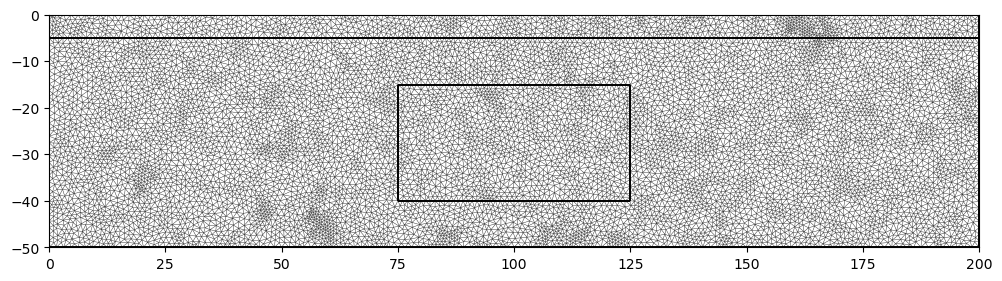

In [24]:
# for p in scheme.sensors():
# 	model.createNode(p)
# 	model.createNode(p - [0., 1])

mesh = mt.createMesh(model, quality=34, area=1)
pg.show(mesh)
plt.gcf().set_size_inches(12,9)

Para que un estudio de refracción sísmica funcione correctamente, las capas deben aumentar su velocidad conforme amentan su profundidad.

Regiones: [2 2 2 ... 2 2 2]
Velocidades: [800 800 800 ... 800 800 800]


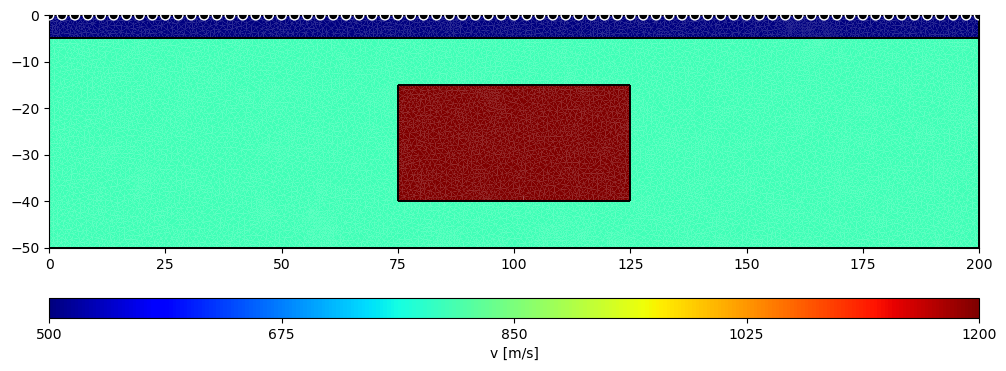

In [25]:
# Otra forma de asignar las velocidades a las regiones de la malla
vp = np.array(mesh.cellMarkers())
print('Regiones:', vp)
vp[vp == 1] = 500
vp[vp == 2] = 800
vp[vp == 3] = 1200
vp[vp == 4] = 1500
vp[vp == 5] = 3000
print('Velocidades:', vp)

# Muestra el modelo con los geófonos
ax, _ = pg.show(mesh, vp, colorBar=True, label='v [m/s]', cMap='jet')
pg.viewer.mpl.drawSensors(ax, scheme.sensors(), diam=2.0, facecolor='k', edgecolor='w')
plt.gcf().set_size_inches(12,9)

plt.show()

# Simulación de datos sintéticos

El tiempo de viaje de una onda depende de las capas y la distribución de velocidaddes bajo la superficie. De manera general, la fórmula para obtener el tiempo de viaje de una onda refractada para un medio con dos capas horizontales cuya velocidad aumenta con la profundidad es:

$$

t_{refr} = \frac{x}{V_2} + \frac{2h\sqrt{V_2^2 - V_1^2}}{V_1V_2}

$$

19/01/24 - 08:43:27 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.


min/max t: 0.005208333333333314 0.24829671974771766


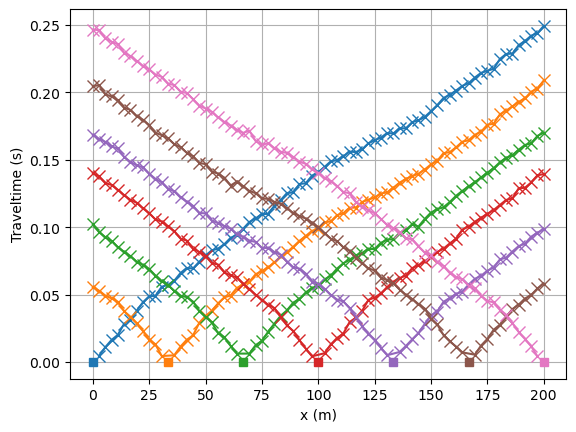

In [26]:
noise = 1e-03

data = tt.simulate(slowness=1/vp, mesh=mesh, scheme=scheme, noiseLevel=noise, noiseAbs=noise, seed=1337, verbose=True)
tt.show(data)
plt.gca().invert_yaxis()

# Inversión de datos

In [31]:
import pygimli.physics.traveltime as tt

mgr = tt.TravelTimeManager(data)

# secNodes modifica la calidad de la inversión pero aumenta considerablemente el tiempo de ejecución (max 2)
# paraMaxCellSize aumenta la resolución a costa del tiempo de ejecución
vest = mgr.invert(
				  secNodes=3, paraMaxCellSize=2.0,
                  #maxIter=10, 
				  verbose=True,
				  lam=20)
# np.testing.assert_array_less(mgr.inv.inv.chi2(), 1.1)

19/01/24 - 08:45:50 - pyGIMLi - INFO - Found 1 regions.
19/01/24 - 08:45:51 - pyGIMLi - INFO - Found 1 regions.
19/01/24 - 08:45:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
19/01/24 - 08:45:51 - pyGIMLi - INFO - Creating refined mesh (secnodes: 3) to solve forward task.
19/01/24 - 08:45:52 - pyGIMLi - INFO - Create gradient starting model. 500: 5000
19/01/24 - 08:45:52 - pyGIMLi - INFO - Created startmodel from forward operator: 13077, min/max=0.000200/0.002000
19/01/24 - 08:45:52 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x000001BCF97823B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000001BCA3222540>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000001BCA3222810>
min/max (data): 0.0041/0.25
min/max (error): 0.5%/24.6%
min/max (start model): 2.0e-04/0.002
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1628.86
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   29.82 (dPhi = 98.14%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    5.45 (dPhi = 81.02%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    1.51 (dPhi = 69.08%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    0.92 (dPhi = 34.57%) l

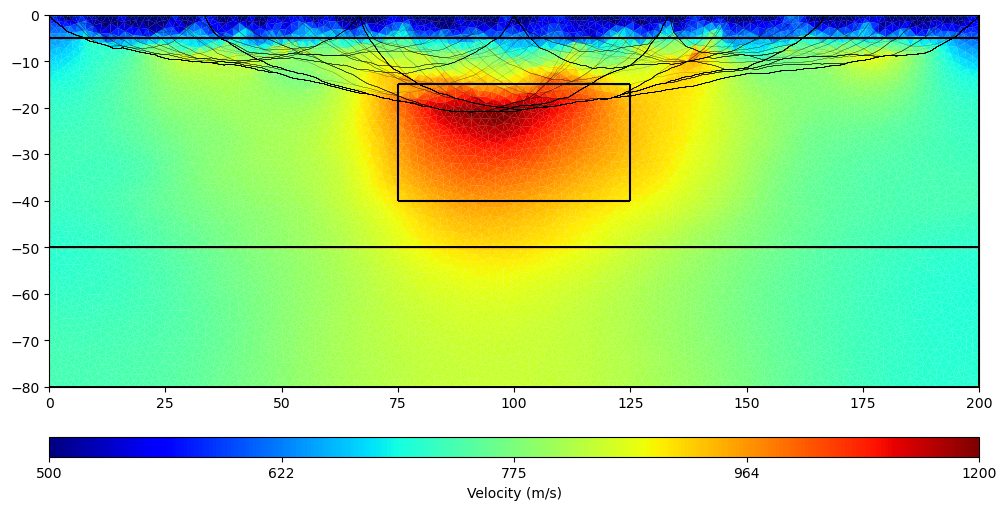

In [32]:
ax,_ = mgr.showResult(cMin=min(vp), cMax=max(vp), cMap='jet')

# La trayectoria de los rayos muestran en qué regiones hay más información y dónde es confiable
rays = mgr.drawRayPaths(ax=ax, color="k", lw=0.1, alpha=0.5)

pg.show(model, fillRegion=False, regionMarker=False, ax=ax)

plt.gcf().set_size_inches(12,9)
# plt.ylim(-40,0)
plt.show()

In [33]:
# mgr.showFit(firstPicks=True)
# plt.gcf().set_size_inches(8,6)


In [34]:
end = perf_counter()
print(f'Total running time of the script: {round(end-start, 4)} seconds')

Total running time of the script: 410.7568 seconds
